In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
import os

In [11]:
# Set parameters
batch_size = 8 #16 #8
img_height = 150
img_width = 150
num_classes = 6
num_folds = 5

# Load the dataset
dataset_dir = r"C:\Users\Stefano\Desktop\Stefano\Universita_Bocconi\2_Magistrale\Associazione\Image_Classification_with_CNN\data\seg_train\seg_train"

# Use os.path.normpath to handle the path properly
dataset_dir = os.path.normpath(dataset_dir)

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 14034 files belonging to 6 classes.


In [12]:
# DO NOT RUN THIS

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
])

kf = KFold(n_splits=num_folds, shuffle=True, random_state=31)


#state:

val_f1 = []
val_precision = []
val_recall = []

all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []
all_conf_matrix = []

# Convert the dataset to numpy arrays
images = []
labels = []
for img, lbl in dataset:
    images.append(img)
    labels.append(lbl)

images = np.concatenate(images)
labels = np.concatenate(labels)

In [13]:
# Splitting the data into train and test

train_ds = tf.keras.utils.image_dataset_from_directory(
  r"C:\Users\Stefano\Desktop\Stefano\Universita_Bocconi\2_Magistrale\Associazione\Image_Classification_with_CNN\data\seg_train\seg_train",
  #validation_split=0.3,
  #subset="training",
  seed=341,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  r"C:\Users\Stefano\Desktop\Stefano\Universita_Bocconi\2_Magistrale\Associazione\Image_Classification_with_CNN\data\seg_test\seg_test",
  #validation_split=0.3,
  #subset="validation",
  seed=341,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [14]:
n_iterations = 1  # Number of random search iterations
best_params = {}
best_val_accuracy = 0.0

param_grid = {
    'num_filters': [16, 16, 16], #[16, 32, 64],
    'kernel_size': [3,3], #[3, 5],
    'learning_rate': [0.0005, 0.0005, 0.0005] #[0.001, 0.005, 0.01], #best learning_rate: 0.0005
}

# Define the lambda value for L1 regularization strength
l1_lambda = 0.01
l1_lambda_1 = 0.001


for i in range(n_iterations):
    params = {k: random.choice(v) for k, v in param_grid.items()}
    print(f"Training with parameters: {params}")
    model = tf.keras.Sequential([
                tf.keras.layers.Rescaling(1./255),
                tf.keras.layers.Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
                tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                #tf.keras.layers.Conv2D(params['num_filters'], params['kernel_size'], activation='relu'),
                #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l1(l1_lambda_1), activation='relu'),
                tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l1(l1_lambda_1), activation='relu'),
                tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l1(l1_lambda_1), activation='relu'),
                #tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(6)
            ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    #train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

    history = model.fit(
        train_ds,
        epochs= 27, #18,
        validation_data=val_ds,
        verbose=1
    )

    current_val_accuracy = history.history['val_accuracy'][-1]
    if current_val_accuracy > best_val_accuracy:
            best_val_accuracy = current_val_accuracy
            best_params = {
                'num_filters': params['num_filters'],
                'kernel_size': params['kernel_size'],
                'learning_rate': params['learning_rate'],
            }
    y_pred = np.argmax(model.predict(val_ds), axis=1)
    y_true = [y for _, y in val_ds]
    y_true = np.concatenate(y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"Fold: F1 Score = {f1}, Precision = {precision}, Recall = {recall}")
print(f"Best validation accuracy achieved: {best_val_accuracy}")
print(f"Best parameters: {best_params}")

Training with parameters: {'num_filters': 16, 'kernel_size': 3, 'learning_rate': 0.0005}
Epoch 1/27
14034/14034 [==============================] - 298s 21ms/step - loss: 1.3077 - accuracy: 0.5235 - val_loss: 1.0795 - val_accuracy: 0.6223
Epoch 2/27
14034/14034 [==============================] - 285s 20ms/step - loss: 1.0307 - accuracy: 0.6207 - val_loss: 0.9471 - val_accuracy: 0.6377
Epoch 3/27
14034/14034 [==============================] - 281s 20ms/step - loss: 0.9463 - accuracy: 0.6451 - val_loss: 0.9231 - val_accuracy: 0.6580
Epoch 4/27
14034/14034 [==============================] - 279s 20ms/step - loss: 0.8733 - accuracy: 0.6926 - val_loss: 0.8071 - val_accuracy: 0.7363
Epoch 5/27
14034/14034 [==============================] - 282s 20ms/step - loss: 0.7961 - accuracy: 0.7308 - val_loss: 0.7483 - val_accuracy: 0.7640
Epoch 6/27
14034/14034 [==============================] - 288s 21ms/step - loss: 0.7473 - accuracy: 0.7543 - val_loss: 0.7949 - val_accuracy: 0.7293
Epoch 7/27
14034/

In [7]:
best_params = {'num_filters': 16, 'kernel_size': 3, 'learning_rate': 0.0005}
print(best_params)

{'num_filters': 32, 'kernel_size': 3, 'learning_rate': 0.001}


In [14]:
val_f1 = []
val_precision = []
val_recall = []

all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []
all_conf_matrix = []

# K-Fold Cross-Validation loop
for train_index, val_index in kf.split(images):
    train_x, val_x = images[train_index], images[val_index]
    train_y, val_y = labels[train_index], labels[val_index]

    train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(batch_size)

    # Define the model architecture
    model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(best_params['num_filters'], best_params['kernel_size']),
    tf.keras.layers.PReLU(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(best_params['num_filters'], best_params['kernel_size']),
    tf.keras.layers.PReLU(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Dense(5)
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    #apply data augmentation
    #train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


    # Train the model
    history = model.fit(
        train_ds,
        epochs=16,
        validation_data=val_ds,
        verbose=1
    )

    # Save metrics
    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    # Generate confusion matrix for this fold and save
    y_pred = np.argmax(model.predict(val_ds), axis=1)
    y_true = [y for _, y in val_ds]
    y_true = np.concatenate(y_true)
    conf_matrix = confusion_matrix(y_true, y_pred)
    all_conf_matrix.append(conf_matrix)

    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    val_f1.append(f1)
    val_precision.append(precision)
    val_recall.append(recall)

    print(f"Fold {len(val_f1)}: F1 Score = {f1}, Precision = {precision}, Recall = {recall}")


TypeError: only integer scalar arrays can be converted to a scalar index

Average validation loss: [1.63809947 1.57004869 1.57823741 1.58390168 1.59718271 1.64854876
 1.79479106 1.79470774 1.91739702 1.94502064 1.78962644 1.94006153
 2.04888801 2.25957529 2.19884829 2.30378993]
Average validation accuracy: [0.27142858 0.2044818  0.2439776  0.28235295 0.3114846  0.32212886
 0.27310925 0.30196079 0.29271709 0.31204482 0.3022409  0.32156863
 0.27254903 0.30168068 0.29243698 0.33081234]
Average validation F1 Score: 0.3164686592553735
Average validation Precision: 0.45749718690895164
Average validation Recall: 0.330812324929972


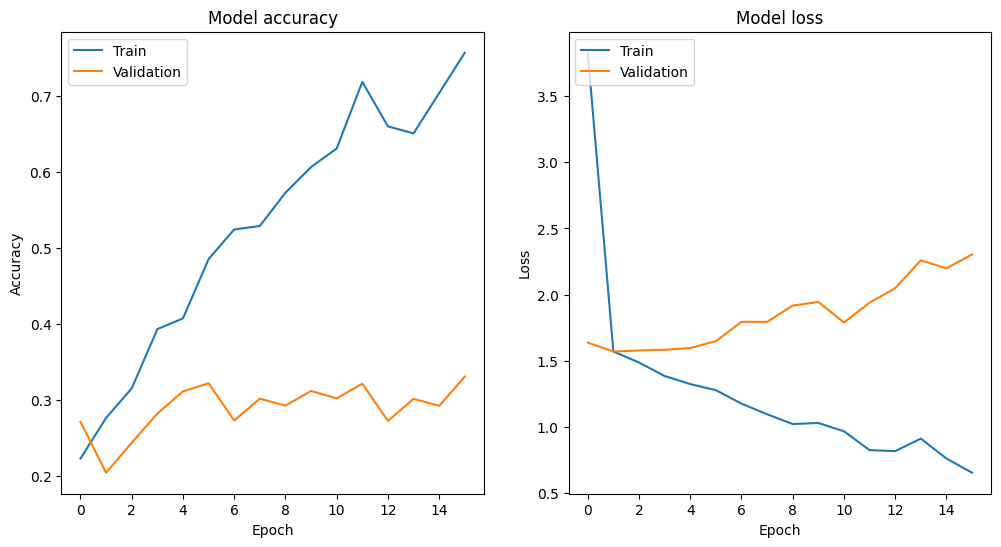

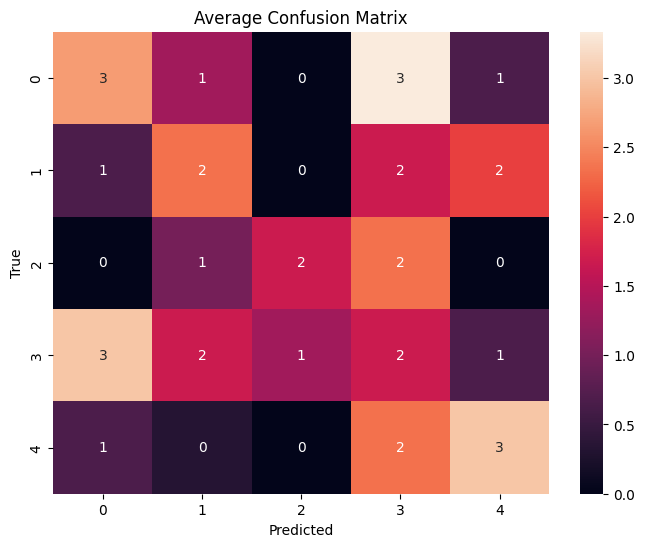

In [ ]:
# Average metrics and plot
avg_train_acc = np.mean(all_train_acc, axis=0)
avg_val_acc = np.mean(all_val_acc, axis=0)
avg_train_loss = np.mean(all_train_loss, axis=0)
avg_val_loss = np.mean(all_val_loss, axis=0)
avg_conf_matrix = np.mean(all_conf_matrix, axis=0)

# Calculate and print average performance metrics across all folds

avg_val_f1 = np.mean(val_f1)
avg_val_precision = np.mean(val_precision)
avg_val_recall = np.mean(val_recall)

print(f"Average validation loss: {avg_val_loss}")
print(f"Average validation accuracy: {avg_val_acc}")
print(f"Average validation F1 Score: {avg_val_f1}")
print(f"Average validation Precision: {avg_val_precision}")
print(f"Average validation Recall: {avg_val_recall}")

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(avg_train_acc)
plt.plot(avg_val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(avg_train_loss)
plt.plot(avg_val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')



plt.show()

# Plot average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(avg_conf_matrix, annot=True, fmt=".0f")
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 [==============================] - 0s 169ms/step


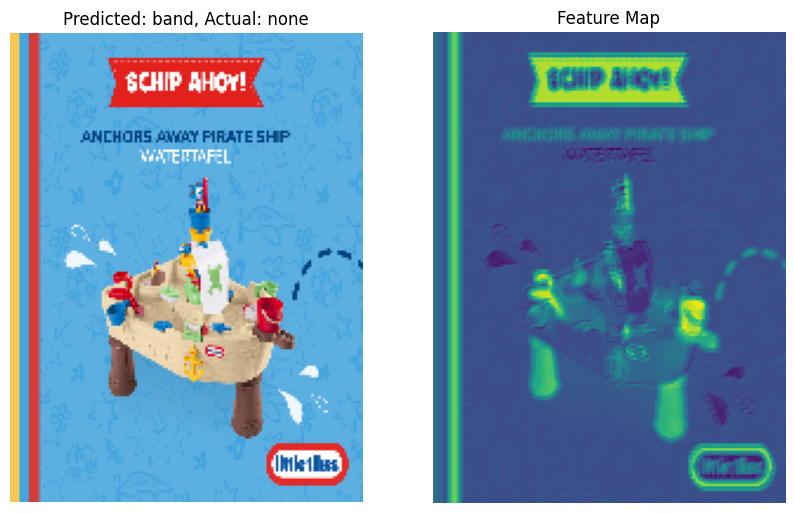

Predicted class: band
Actual class: none
1/1 [==============================] - 0s 67ms/step


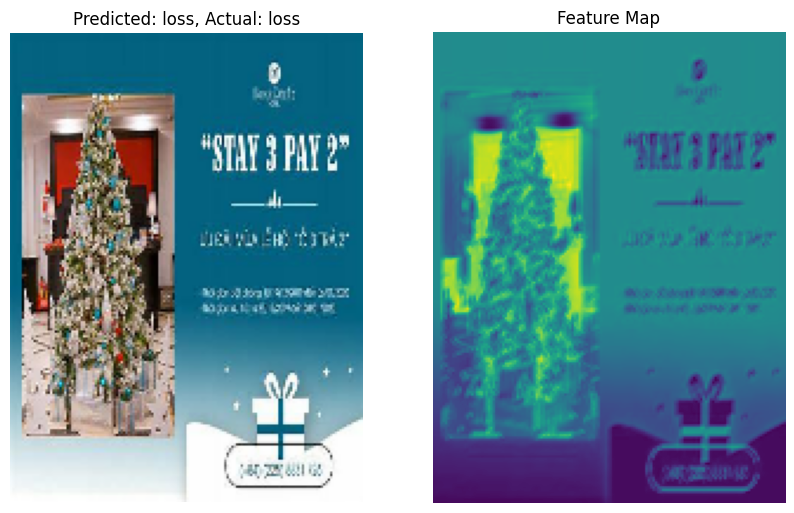

Predicted class: loss
Actual class: loss
1/1 [==============================] - 0s 62ms/step


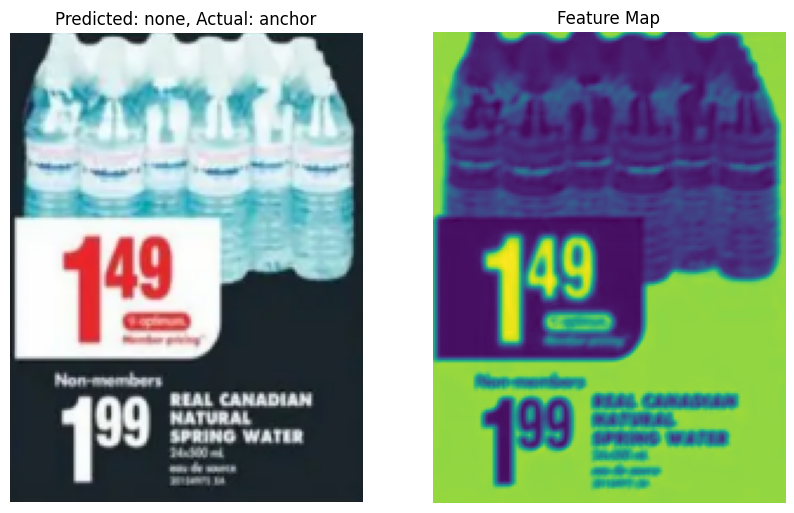

Predicted class: none
Actual class: anchor
1/1 [==============================] - 0s 39ms/step


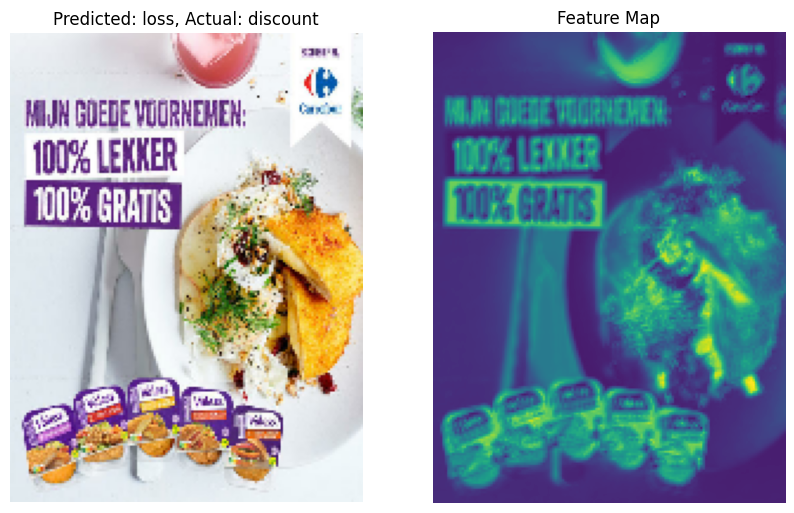

Predicted class: loss
Actual class: discount


In [ ]:
# Assuming test_ds is your test dataset
# and class_names are the names of the classes in the same order as during training
class_names = ['anchor', 'band', 'discount', 'loss', 'none'] # Replace with your actual class names

# Create an intermediate model to get the feature maps
intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('conv2d_10').output)  # Replace 'conv2d' with the name of your first Conv2D layer

# Take one batch of images from your test dataset
for img_batch, label_batch in val_ds.take(4):
    # Take the first image and label from this batch
    img = img_batch[3]
    label = label_batch[3]

    # Expand dimensions for prediction (model expects a batch)
    img_expanded = np.expand_dims(img, axis=0)

    # Make prediction
    predictions = model.predict(img_expanded)
    predicted_class_index = np.argmax(predictions[0])

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    # Get the actual class name
    actual_class_name = class_names[label]

    # Get feature maps
    feature_map = intermediate_model.predict(img_expanded)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"Predicted: {predicted_class_name}, Actual: {actual_class_name}")
    plt.axis('off')

    # Display feature maps
    plt.subplot(1, 2, 2)
    plt.imshow(feature_maps[0, :, :, 0], cmap='viridis')
    plt.title("Feature Map")
    plt.axis('off')

    plt.show()

    print(f"Predicted class: {predicted_class_name}")
    print(f"Actual class: {actual_class_name}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save('anchoring')

In [ ]:
print()